<a href="https://colab.research.google.com/github/santoryudeadman/whisper/blob/main/Fuyu_prompt_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running advanced prompts on Fuyu-8b

The latest model from adept AI labs has VQA, OCR and bbox localization capabilities: this simple notebook will showcase how to run them!

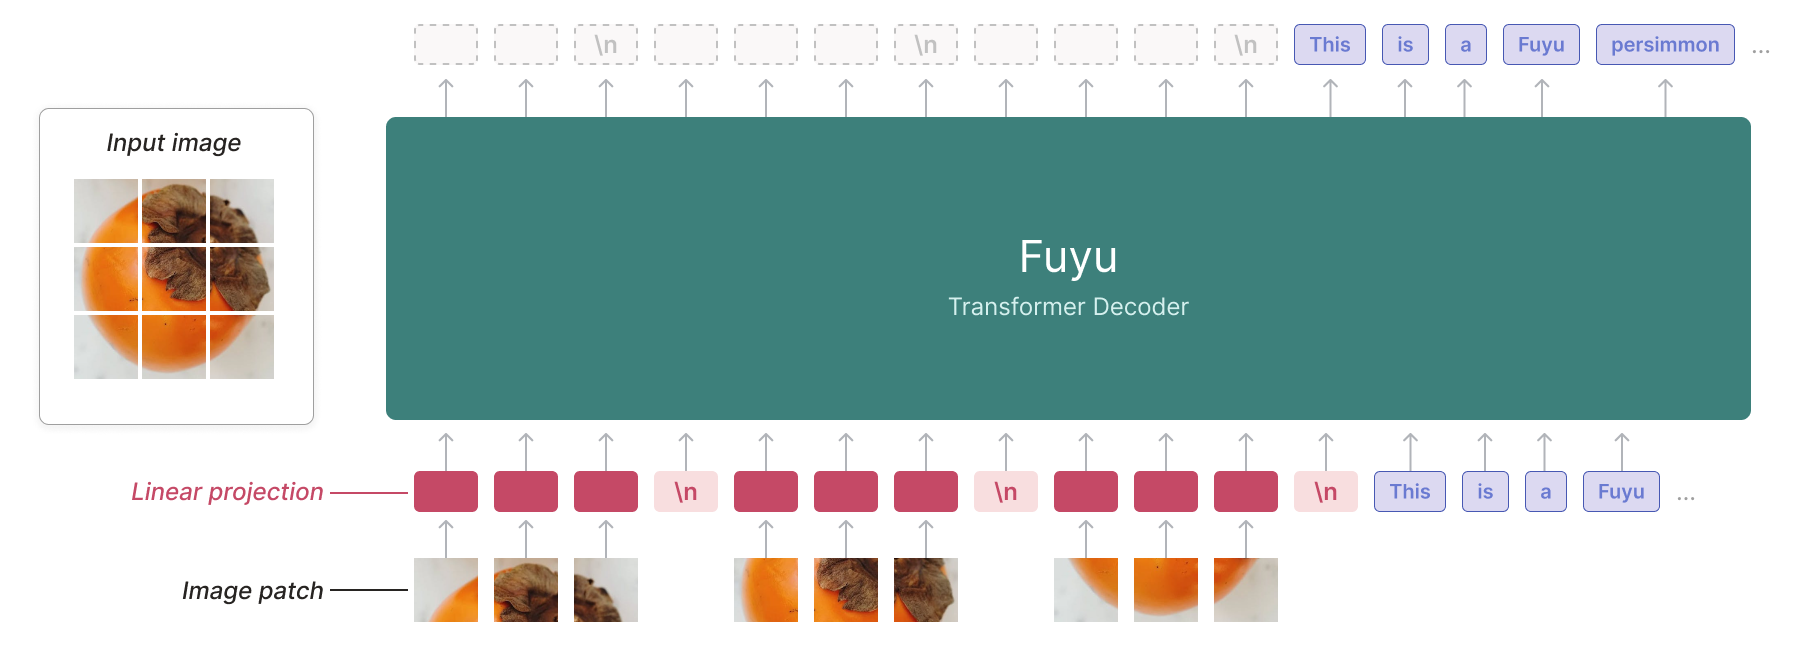



## Install required packages

In [ ]:
!pip install -q transformers bitsandbytes accelerate

## Load the model

Here we'll run a quantized version of the model on this free-tier colab, thanks to the amazing Younes Belkada :)

In [ ]:
import requests
from transformers import FuyuForCausalLM, FuyuProcessor, BitsAndBytesConfig
from PIL import Image
import torch
import io

model_id = "adept/fuyu-8b"
processor = FuyuProcessor.from_pretrained(model_id)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# VQA prompts
Note: due to torch.float16 precision, we have some differences with torch.float32 and torch.bfloat16. Instead of fish, for instance, we can get fish, carrots, lemon in float32. Try it out!

In [ ]:

text_prompt = "Answer the following DocVQA question based on the image. \n What if the maximum male life expectancy?"
chart_image_url = "https://huggingface.co/datasets/hf-internal-testing/fixtures-captioning/resolve/main/chart.png"
chart_image_pil = Image.open(io.BytesIO(requests.get(chart_image_url).content))


second_text_prompt = "Answer the following VQAv2 question based on the image: What type of foods are in the image?"
fish_image_url = "https://huggingface.co/datasets/hf-internal-testing/fixtures-captioning/resolve/main/fish_carrots.png"
fish_image_pil = Image.open(io.BytesIO(requests.get(fish_image_url).content))

# Batch the model inputs, attention masks will be automatically inferred

texts = [text_prompt, second_text_prompt]
images = [chart_image_pil, fish_image_pil]

model_inputs = processor(text=texts, images=images).to('cuda', torch.float16)


model_outputs = processor.tokenizer.batch_decode(model.generate(
    **model_inputs, max_new_tokens=10)[:, -10:], skip_special_tokens=True)

ground_truths = ['80.7', 'fish']

# Compare with ground truths

for ground_truth, model_output in zip(ground_truths, model_outputs):
    prediction = model_output.split('\x04 ', 1)[1] if '\x04' in model_output else ''
    print(prediction, ground_truth)

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


80.7 80.7
fish fish


# Guided OCR prompts
The following bounding box coordinates circle the word "Williams" in the picture.

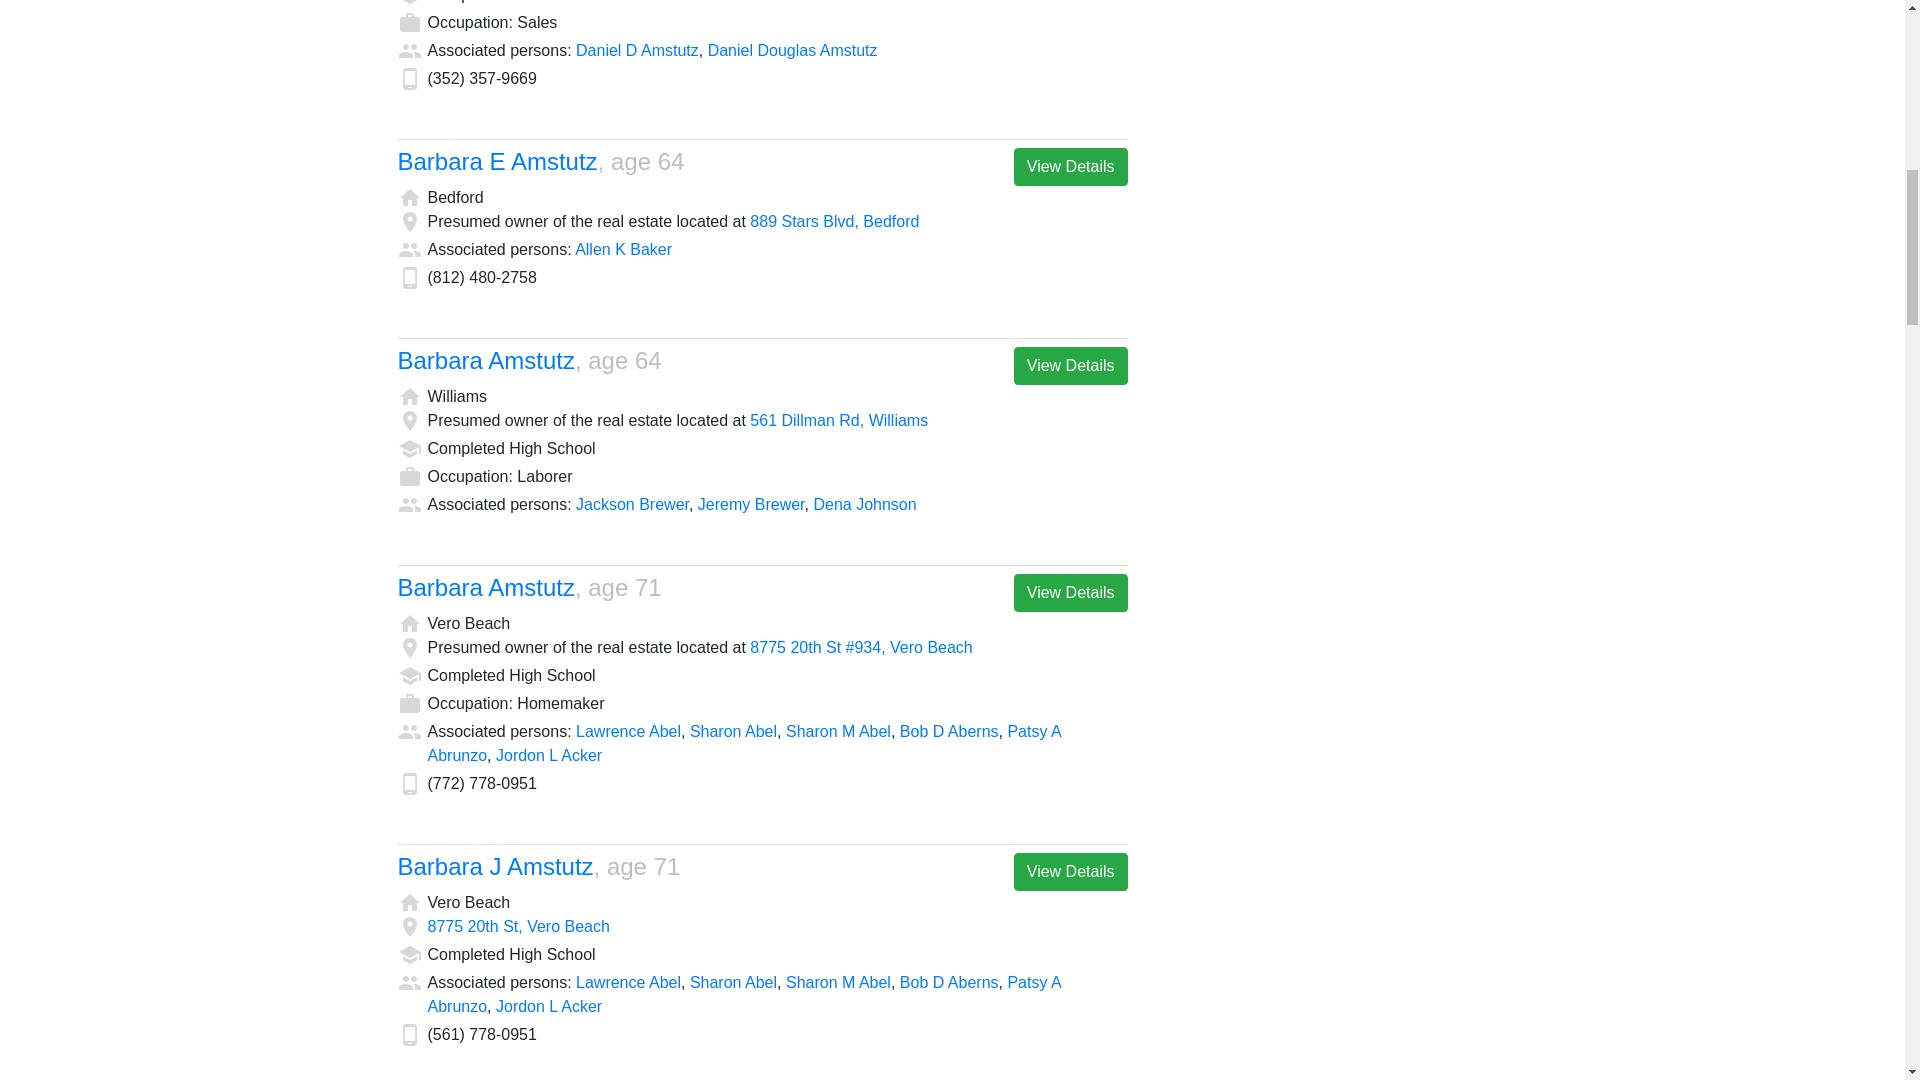

In [ ]:
bbox_prompt = "When presented with a box, perform OCR to extract text contained within it. If provided with text, generate the corresponding bounding box.\\n<box>388, 428, 404, 488</box>"
bbox_image_url = "https://huggingface.co/datasets/hf-internal-testing/fixtures-captioning/resolve/main/bbox_sample_image.jpeg"
bbox_image_pil = Image.open(io.BytesIO(requests.get(bbox_image_url).content))
bbox_image_pil

In [ ]:

model_inputs = processor(text=bbox_prompt, images=bbox_image_pil).to('cuda', torch.float16)


model_outputs = processor.batch_decode(model.generate(
    **model_inputs, max_new_tokens=10)[:, -10:], skip_special_tokens=True)[0]
prediction = model_outputs.split('\x04', 1)[1] if '\x04' in model_outputs else ''
print(prediction)

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


 Williams


#Bounding box localization prompts
Finally, we can recover a bounding box with coordinates containing "Williams", the text prompted.

In [ ]:
bbox_prompt = "When presented with a box, perform OCR to extract text contained within it. If provided with text, generate the corresponding bounding box.\\n Williams"
bbox_image_url = "https://huggingface.co/datasets/hf-internal-testing/fixtures-captioning/resolve/main/bbox_sample_image.jpeg"
bbox_image_pil = Image.open(io.BytesIO(requests.get(bbox_image_url).content))
model_inputs = processor(text=bbox_prompt, images=bbox_image_pil).to('cuda', torch.float16)

outputs = model.generate(**model_inputs, max_new_tokens=10)
post_processed_bbox_tokens = processor.post_process_box_coordinates(outputs)[0]
model_outputs = processor.decode(post_processed_bbox_tokens, skip_special_tokens=True)
prediction = model_outputs.split('\x04', 1)[1] if '\x04' in model_outputs else ''
print(prediction)


Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


<box>388, 428, 404, 900</box>
